In [1]:
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

import olympus
from olympus.scalarizers import Scalarizer
from olympus.datasets import Dataset

In [3]:
def get_traces(data, scalarizer):
    ''' returns the best merit traces
    '''
    traces = []
    for df in data:
        scalarized = scalarizer.scalarize(df.loc[:, [ 'drug_loading', 'encap_efficiency', 'particle_diameter']].values)
        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        trace0 = [df.loc[i, 'drug_loading'] for i in trace_best_idx]
        trace1 = [df.loc[i, 'encap_efficiency'] for i in trace_best_idx]
        trace2 = [df.loc[i, 'particle_diameter'] for i in trace_best_idx]
        traces.append([trace0, trace1, trace2])
    return np.array(traces)

def get_rank_traces(data, dataset, scalarizer):
    scalarized = scalarizer.scalarize(dataset.data.loc[:, [ 'drug_loading', 'encap_efficiency', 'particle_diameter']].values)
    dataset.data['scalarized'] = scalarized
    dataset.data = dataset.data.sort_values(by='scalarized')
    dataset.data['rank'] = np.arange(len(scalarized))+1

    traces = []
    for df in data:
        print(df.head())
        df['rank'] = 0.
        merged = pd.merge(df, dataset.data, how='left', on=param_names+obj_names, )#right_on='rank')
        print(merged.head())
#         print(data.head())
#         print(merged.shape)
#         print('-'*75)
        ranks = merged['rank_y'].cummin().to_list()
        print(ranks)
#         print(len(ranks))
        traces.append(ranks[:df.shape[0]])
    return np.array(traces)
            


def get_frac_tol(data):
    ''' returns the fraction of tolerable molecules uncovered at each iteration
    '''
    traces = []
    df_tol = df_results[
            (df_results['ered']>chimera.tolerances[0])&
            (df_results['gsol']<chimera.tolerances[1])&
            (df_results['abs_lam_diff']>chimera.tolerances[2])
        ]
    for df in data:
        frac_tols  = []
        for i in range(df.shape[0]): 
            sub_df = df.iloc[:i+1, :]
            data_tol = sub_df[
                    (sub_df['ered']>chimera.tolerances[0])&
                    (sub_df['gsol']<chimera.tolerances[1])&
                    (sub_df['abs_lam_diff']>chimera.tolerances[2])
                ]
            frac_tol = data_tol.shape[0] / df_tol.shape[0]
            frac_tols.append(frac_tol)
        traces.append(frac_tols)
        
    return np.array(traces)   # (num_runs, num_iterations)


def get_num_evals_best(data, best_objs):
    num_evals = []
    for d in data: 
        ix = d.index[
            (d['drug_loading']==best_objs[0])&\
            (d['encap_efficiency']==best_objs[1])&\
            (d['particle_diameter']==best_objs[2])
        ].tolist()
        if ix != []:
            num_evals.append(ix[0])
        else:
            num_evals.append(d.shape[0])
        
    return num_evals

def get_num_batches_best(data, best_objs, batch_size):
    num_batches = []
    for d in data:
        ix = d.index[
            (d['drug_loading']==best_objs[0])&\
            (d['encap_efficiency']==best_objs[1])&\
            (d['particle_diameter']==best_objs[2])
        ].tolist()
        if ix!=[]:
            num_batches.append(math.ceil(ix[0]/batch_size))
        else:
            num_batches.append(math.ceil(data.shape[0]/batch_size))
    return num_batches
    

def get_num_evals_threshold(data, target_objs):
    num_evals = []
    for d in data:
        ix = d.index[
            (d['drug_loading']>=targets_objs[0])&\
            (d['encap_efficiency']>=target_objs[1])&\
            (d['particle_diameter']<=target_objs[2])
        ].tolist()
        if ix != []:
            num_evals.append(min(ix))
        else:
            num_evals.append(d.shape[0])
            
    return num_evals

def plot_rank_trace_mean(data, dataset, scalarizer, ax=None, color=None, label=None, use_std_err=True):
        
    traces = get_rank_traces(data, dataset, scalarizer)
    if ax is None:
        fig, ax = plt.subplots()
    
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=5, zorder=11)
    ax.plot(x, mean, color=color, linewidth=4, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    
    
def plot_trace_mean(data, scalarizer, obj_num=0, ax=None, color=None, label=None, use_std_err=True):
        
    traces = get_traces(data, scalarizer)[:, obj_num, :]
    if ax is None:
        fig, ax = plt.subplots()
    
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=5, zorder=11)
    ax.plot(x, mean, color=color, linewidth=4, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


# def plot_trace_sigle(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
#     with open(pkl_file, 'rb') as content:
#         data = pickle.load(content)
#     plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    

def gradient_patch(ax, xmin, xmax, ymin, ymax, fill_color='k', alpha=1, zorder=1):
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    
    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, 
                          facecolor='none', edgecolor='none')
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

In [4]:
def num_eval_to_x(res, pd, dl, ee):
    num_evals = []
    for r in res:
        good_evals = r.index[(r['particle_diameter']<=np.log10(pd))&(r['drug_loading']>=dl)&(r['encap_efficiency']>=ee)].tolist()
        if not good_evals == []:
            num_evals.append(np.amin(good_evals)+1)
        else:
            num_evals.append(r.shape[0]) # budget evals
    return num_evals, np.mean(num_evals), np.median(num_evals), np.std(num_evals)

In [5]:
# load resulsts
raw_res_rand = pickle.load(open('../random/results.pkl', 'rb'))
raw_res_bo_1 = pickle.load(open('../botorch/results.pkl', 'rb'))
raw_res_bo_32 = pickle.load(open('../botorch_batched/results.pkl', 'rb'))


print(len(raw_res_rand))
print(len(raw_res_bo_1))
print(len(raw_res_bo_32))


dataset = Dataset('lnp3')

param_names = ['drug_input', 'solid_lipid', 'solid_lipid_input', 'liquid_lipid_input', 'surfractant_input']
obj_names = ['drug_loading', 'encap_efficiency', 'particle_diameter']



40
40
40


[FATAL] Could not find dataset `lnp3`. Please choose from one of the available datasets: vapdiff_crystal, suzuki_i, suzuki_iv, agnp, buchwald_a, photo_pce10, snar, colors_n9, fullerenes, oer_plate_4098, perovskites, benzylation, colors_bob, suzuki_iii, photo_wf3, autoam, hplc, crossed_barrel, suzuki, dye_lasers, suzuki_ii, oer_plate_3851, oer_plate_3860, oer_plate_3496, buchwald_b, buchwald_e, redoxmers, p3ht, thin_film, suzuki_edbo, buchwald_d, buchwald_c, alkox.


SystemExit: 

/opt/anaconda3/envs/atlas/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
max_drug_loading = dataset.data.drug_loading.max()
max_encap_efficiency = dataset.data.encap_efficiency.max()
min_particle_diameter = dataset.data.particle_diameter.min()
print('max drug_loading : ', max_drug_loading)
print('max encap_efficiency : ', max_encap_efficiency)
print('min |300nm-particle_diameter| : ', min_particle_diameter)

params = dataset.data[param_names].values
values = dataset.data[obj_names].values

scalarizer = Scalarizer(kind='Hypervolume', value_space=dataset.value_space, goals=['max', 'max', 'min'])
scalarized = scalarizer.scalarize(values)

idx = np.argsort(scalarized)
sort_params = params[idx]
sort_values = values[idx]
sort_scalarized = scalarized[idx]

best_objs = sort_values[0]
print(sort_params[0])
print(best_objs)



NameError: name 'dataset' is not defined

NameError: name 'scalarizer' is not defined

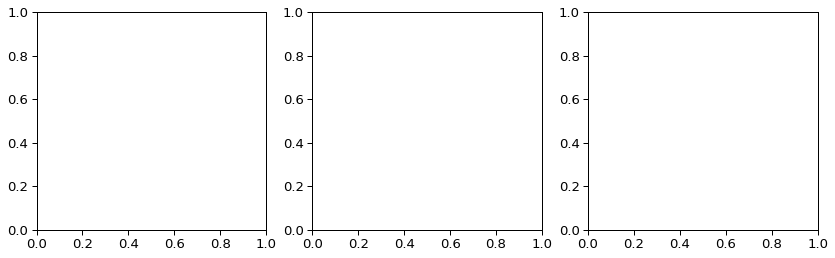

In [7]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4))


plot_trace_mean(raw_res_rand, scalarizer, obj_num=0, ax=ax0, color=None, use_std_err=True, label='Random')
plot_trace_mean(raw_res_bo_1, scalarizer, obj_num=0, ax=ax0, color=None, use_std_err=True, label='Botorch')
#plot_trace_mean(raw_res_gpyopt_cat_1, scalarizer, obj_num=0, ax=ax0, color=None, use_std_err=True, label='Gpyopt cat')
#plot_trace_mean(raw_res_gpyopt_mix_1, scalarizer, obj_num=0, ax=ax0, color=None, use_std_err=True, label='Gpyopt mix')

ax0.axhline(best_objs[0],c='k',lw=2,ls='--') # overall best
ax0.axhline(max_drug_loading,c='k',lw=1,ls=':') # single best


plot_trace_mean(raw_res_rand, scalarizer, obj_num=1, ax=ax1, color=None, use_std_err=True, label='Random')
plot_trace_mean(raw_res_bo_1, scalarizer, obj_num=1, ax=ax1, color=None, use_std_err=True, label='Botorch')
#plot_trace_mean(raw_res_gpyopt_cat_1, scalarizer, obj_num=1, ax=ax1, color=None, use_std_err=True, label='Gpyopt cat')
#plot_trace_mean(raw_res_gpyopt_mix_1, scalarizer, obj_num=1, ax=ax1, color=None, use_std_err=True, label='Gpyopt mix')

ax1.axhline(best_objs[1],c='k',lw=2,ls='--')
ax1.axhline(max_encap_efficiency,c='k',lw=1,ls=':') # single best

plot_trace_mean(raw_res_rand, scalarizer, obj_num=2, ax=ax2, color=None, use_std_err=True, label='Random')
plot_trace_mean(raw_res_bo_1, scalarizer, obj_num=2, ax=ax2, color=None, use_std_err=True, label='Botorch')
#plot_trace_mean(raw_res_gpyopt_cat_1, scalarizer, obj_num=2, ax=ax2, color=None, use_std_err=True, label='Gpyopt cat')
#plot_trace_mean(raw_res_gpyopt_mix_1, scalarizer, obj_num=2, ax=ax2, color=None, use_std_err=True, label='Gpyopt mix')

ax2.axhline(best_objs[2],c='k',lw=2,ls='--')
ax2.axhline(min_particle_diameter,c='k',lw=2,ls=':') # single best

ax0.set_title('Drug loading capacity')
ax1.set_title('Encapsulation efficiency')
ax2.set_title('Deviation from 300nm diameter')

ax0.legend(loc='lower right')

ax0.set_xlabel('# evaluations')
ax1.set_xlabel('# evaluations')
ax2.set_xlabel('# evaluations')

ax0.set_ylabel('drug loading capacity [%]')
ax1.set_ylabel('encapsulation efficiency [%]')
ax2.set_ylabel('| 300 - particle diameter |  [nm]')


ax0.set_xlim(0, 50)
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)# overall best

plt.tight_layout()

In [8]:
num_evals_rand = get_num_evals_best(raw_res_rand, best_objs)
num_evals_bo_1 = get_num_evals_best(raw_res_bo_1, best_objs)

df_rand = pd.DataFrame({'method': ['Grid search' for _ in range(len(num_evals_rand))], 'num_eval': num_evals_rand})
df_bo_1 = pd.DataFrame({'method': ['Model-based\noptimization' for _ in range(len(num_evals_bo_1))], 'num_eval': num_evals_bo_1})

df_num_evals = pd.concat((df_rand, df_bo_1))

print(np.mean(num_evals_rand), np.std(num_evals_rand), np.std(num_evals_rand)/40, np.median(num_evals_rand))
print(np.mean(num_evals_bo_1), np.std(num_evals_bo_1), np.std(num_evals_bo_1)/40, np.median(num_evals_bo_1))

NameError: name 'best_objs' is not defined

NameError: name 'df_num_evals' is not defined

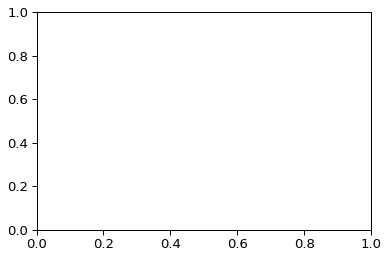

In [9]:
fig, ax0 = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(data=df_num_evals, x='method', y='num_eval', showmeans=True, linewidth=2)
sns.stripplot(data=df_num_evals, x='method', y='num_eval', edgecolor='gray', linewidth=1, size=8)

ax0.set_yscale('log')

ax0.set_xlabel('')
ax0.set_ylabel('# experiments to identify\nbest formulation')
               


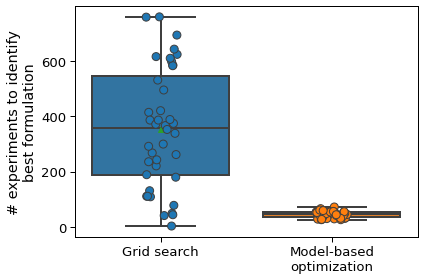

In [101]:
fig, ax0 = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(data=df_num_evals, x='method', y='num_eval', showmeans=True, linewidth=2)
sns.stripplot(data=df_num_evals, x='method', y='num_eval', edgecolor='gray', linewidth=1, size=8)

# ax0.set_yscale('log')

ax0.set_xlabel('')
ax0.set_ylabel('# experiments to identify\nbest formulation')
# ax0.set_ylim(-5, 800)
plt.tight_layout()
plt.savefig('num_evals_best_1by1.png', dpi=400)

In [109]:
num_batches_rand = get_num_batches_best(raw_res_rand, best_objs, batch_size=32)
num_batches_bo_32 = get_num_batches_best(raw_res_bo_32, best_objs, batch_size=32)

df_rand = pd.DataFrame({'method': ['Grid search' for _ in range(len(num_batches_rand))], 'num_eval': num_batches_rand})
df_bo_32 = pd.DataFrame({'method': ['Model-based\noptimization' for _ in range(len(num_batches_bo_32))], 'num_eval': num_batches_bo_32})

df_num_batches = pd.concat((df_rand, df_bo_32))

print(np.mean(num_batches_rand), np.std(num_batches_rand), np.std(num_batches_rand)/40, np.median(num_batches_rand))
print(np.mean(num_batches_bo_32), np.std(num_batches_bo_32), np.std(num_batches_bo_32)/40, np.median(num_batches_bo_32))

12.275 6.652020369782401 0.16630050924456002 12.5
2.4 0.8306623862918076 0.020766559657295187 2.0


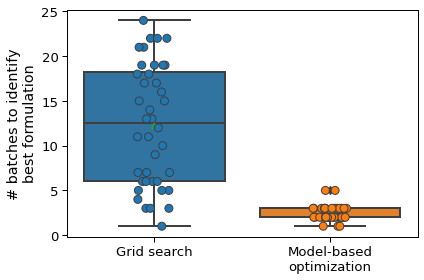

In [113]:
fig, ax0 = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(data=df_num_batches, x='method', y='num_eval', showmeans=True, linewidth=2)
sns.stripplot(data=df_num_batches, x='method', y='num_eval', edgecolor='gray', linewidth=1, size=8)

# ax0.set_yscale('log')

ax0.set_xlabel('')
ax0.set_ylabel('# batches to identify\nbest formulation')
# ax0.set_ylim(-5, 800)
plt.tight_layout()
plt.savefig('num_batches_best_32.png', dpi=300)

In [111]:
12.275/2.4

5.114583333333334

In [112]:
12.5/2

6.25